In [1]:
from utils import dataloader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload  

import matplotlib.pyplot as plt

import numpy as np

import torch as th
import torch.nn as nn
import os
from datetime import datetime
import matplotlib as mpl
import torch.optim as optim
import pytorch_ssim

import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms

In [4]:
dataloader = reload(dataloader)

plotsize = 15

partitions = dataloader.DataPartitions(
    past_frames=4,
    future_frames=1,
    root="../datasets/baganza/10min/",
    partial=0.2
)

dataset = dataloader.DataGenerator(
    root="../datasets/baganza/10min/",
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 4),
    output_dim=(partitions.future_frames, 256, 256, 3),
    batch_size=4,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
    dynamicity = 1e-2
)

In [34]:
X, Y, extra_batch = dataset.get_data()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0


[x] 4 areas found
. . . . . . . . . . . 
[25%] 11 valid sequences loaded
. . . . . . . . . . . 
[50%] 11 valid sequences loaded
. . . . . . . . . . . 
[75%] 11 valid sequences loaded
. . . . . . . . . . 
[100%] 10 valid sequences loaded


In [35]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [75]:
X_train.shape


(8, 4, 4, 256, 256, 4)

In [76]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: -1.13057
BTM min: -0.66074
DEP max: 2.88564
VEL max: 3.21446
BTM max: 2.88887


### Model

In [10]:
import torch.nn.functional as F
from functools import partial

In [11]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [14]:
'''
weights_path = "runs/train_15_04_07_2021_23_28_19/model.weights"
net.load_state_dict(th.load(weights_path))
'''

'\nweights_path = "runs/train_15_04_07_2021_23_28_19/model.weights"\nnet.load_state_dict(th.load(weights_path))\n'

In [77]:
if th.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = th.device(dev)

In [98]:
from models.resnet import convlstm
convlstm = reload(convlstm)

net = convlstm.ConvLSTM(
    input_dim = 4, 
    hidden_dim = 3, 
    kernel_size = (3,3), 
    num_layers = 4,
    batch_first = True, 
    bias = True, 
    return_all_layers = False).to(device) # False: many to one

# _, last_states = net(x)
# h = last_states[0][-1]  # 0 for layer index, 0 for h index


In [99]:
criterion = nn.MSELoss() # reduction='sum'
ssim_loss = pytorch_ssim.SSIM()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [80]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [81]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_train = X_train.permute(0, 1, 2, 5, 3, 4)
y_train = y_train.permute(0, 1, 2, 5, 3, 4)

In [82]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [83]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_test = X_test.permute(0, 1, 2, 5, 3, 4)
y_test = y_test.permute(0, 1, 2, 5, 3, 4)

torch.Size([8, 4, 4, 4, 256, 256])


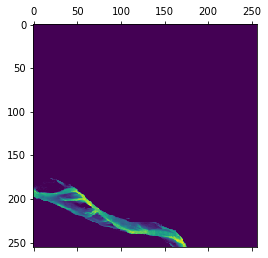

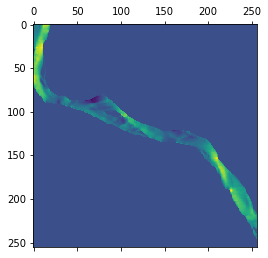

In [86]:
plt.matshow(X[5,2,0,:,:,0])
plt.matshow(X_train[5,2,0,2,:,:])
print(X_train.shape)

<ipython-input-87-a968cc5a6469>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))


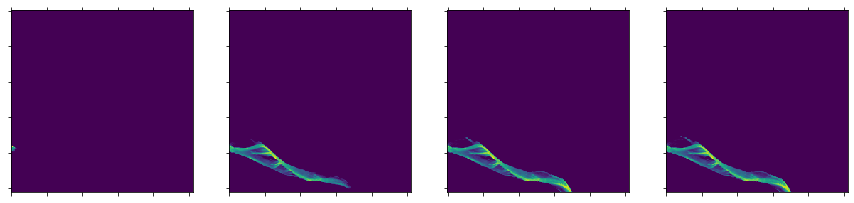

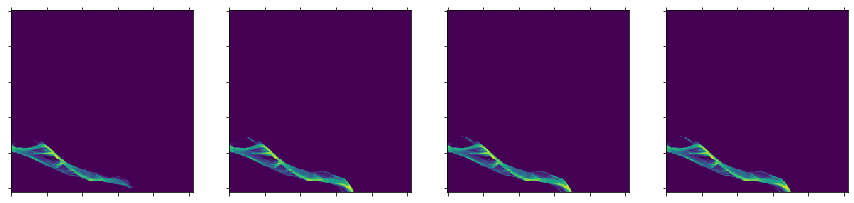

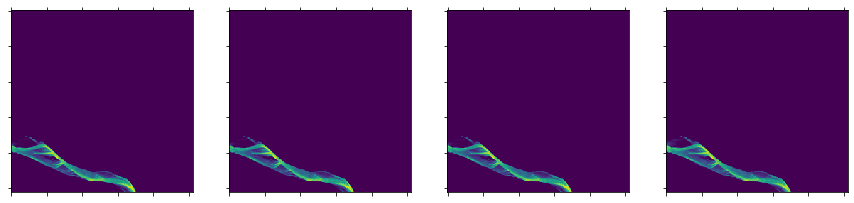

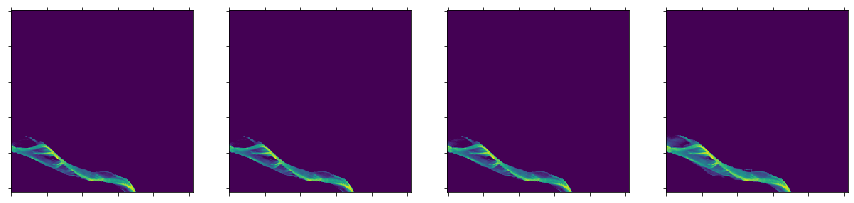

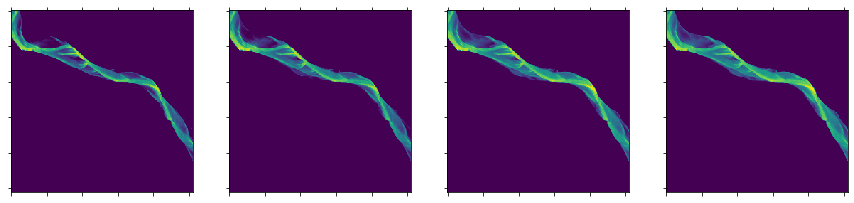

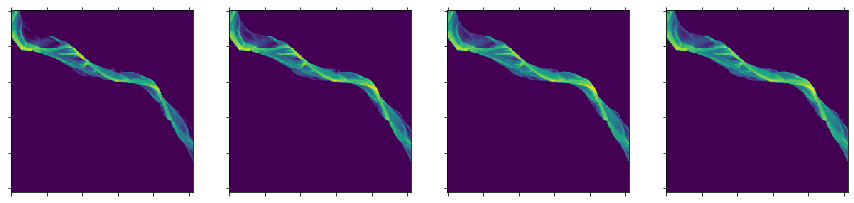

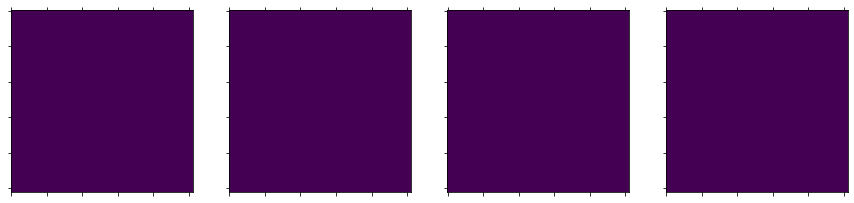

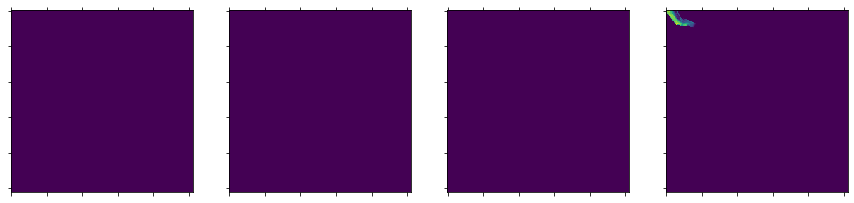

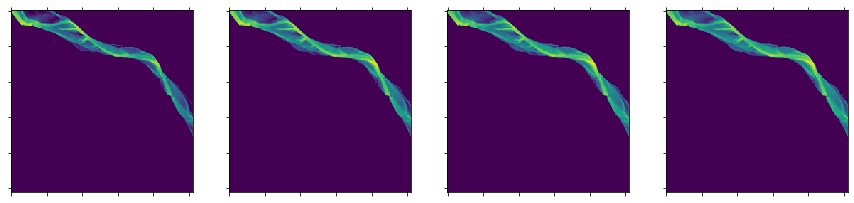

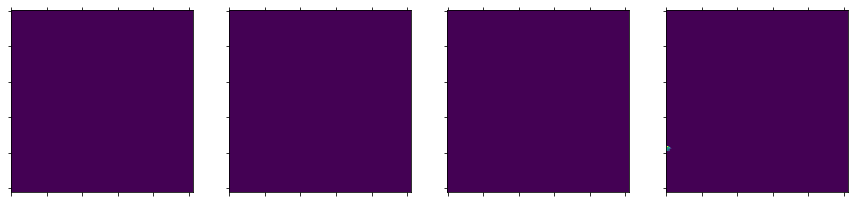

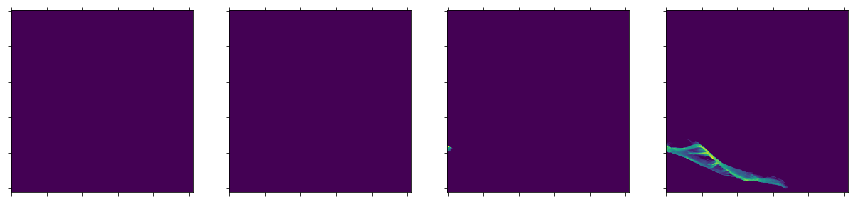

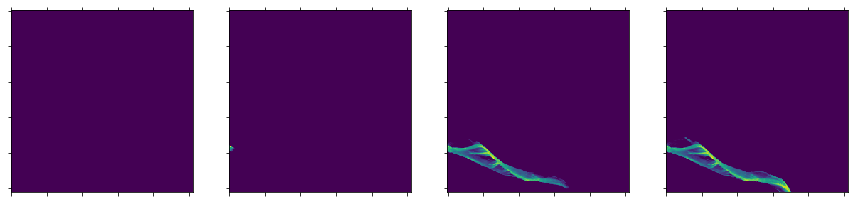

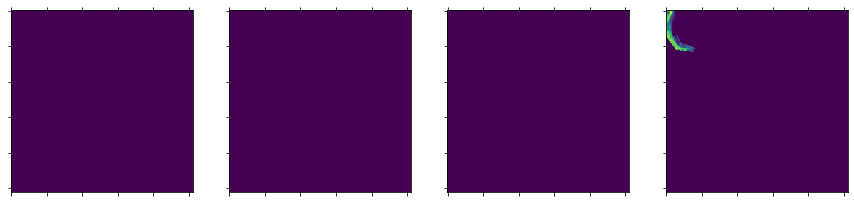

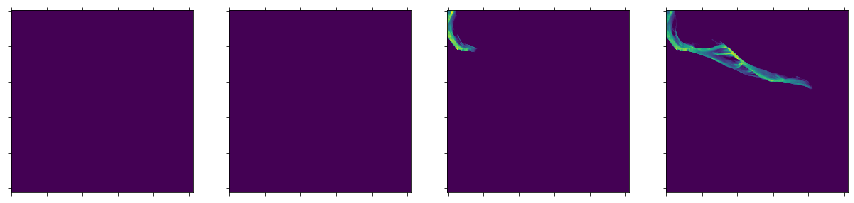

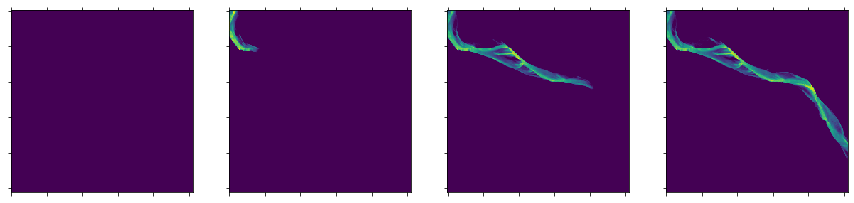

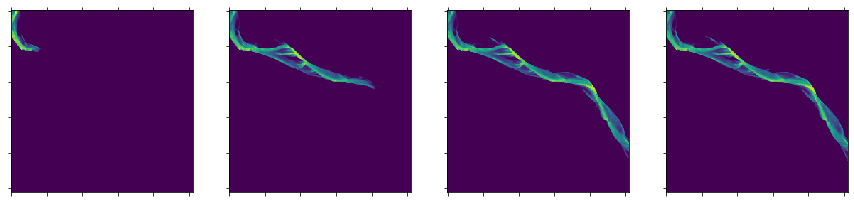

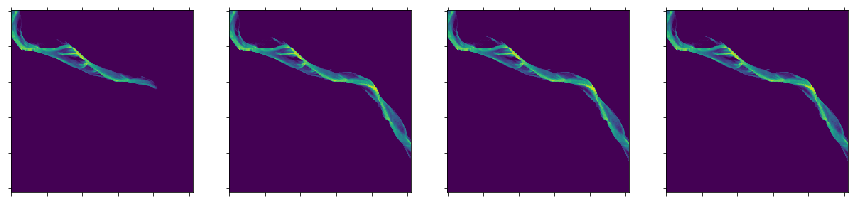

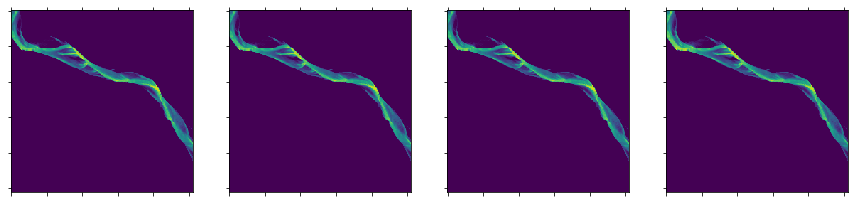

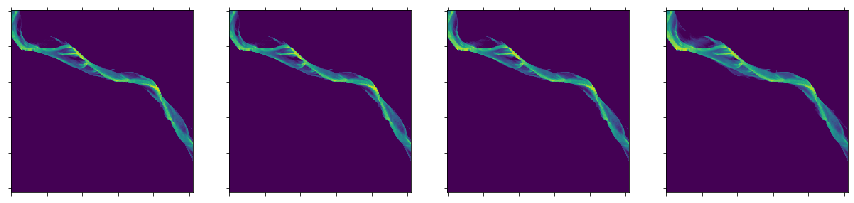

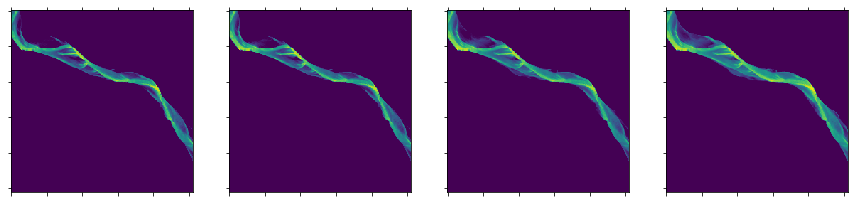

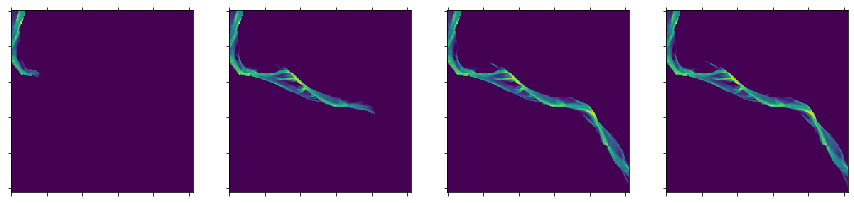

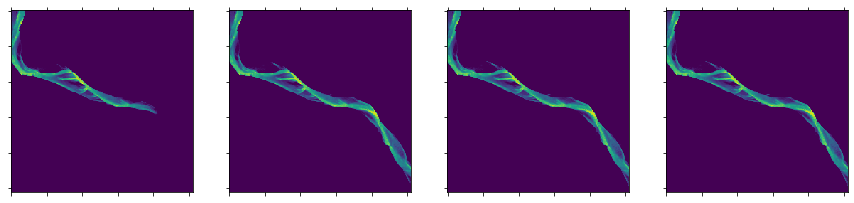

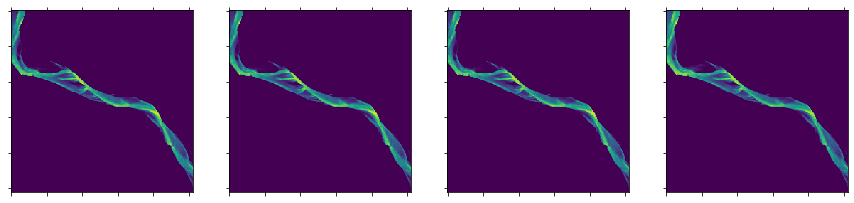

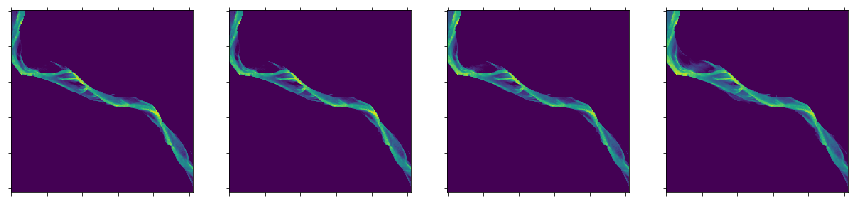

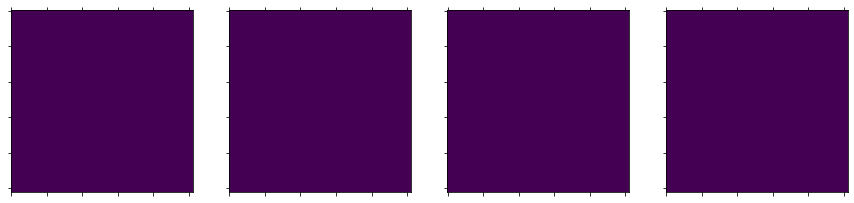

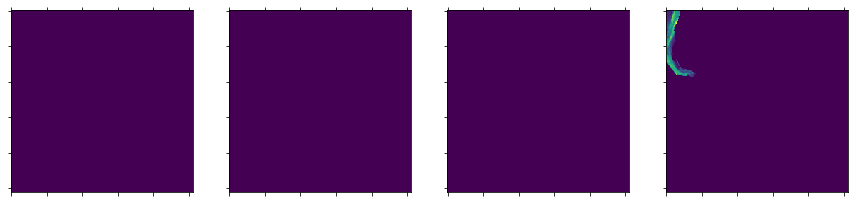

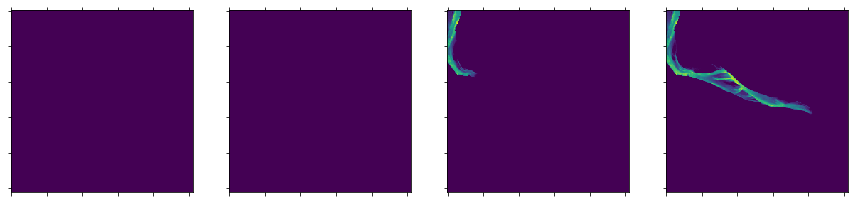

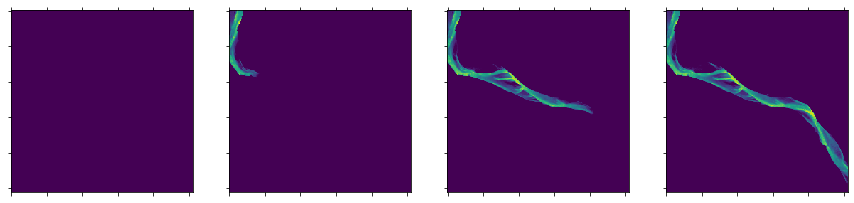

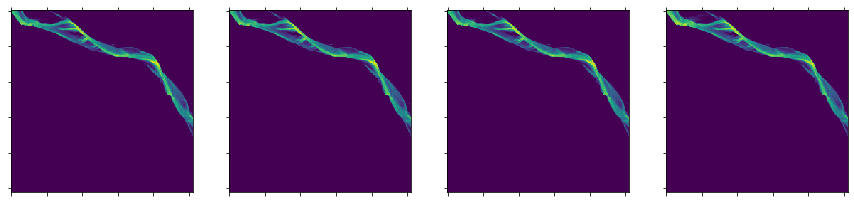

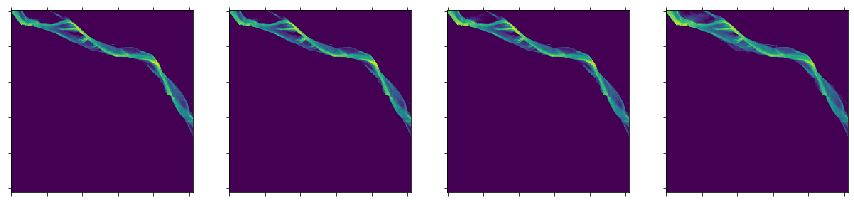

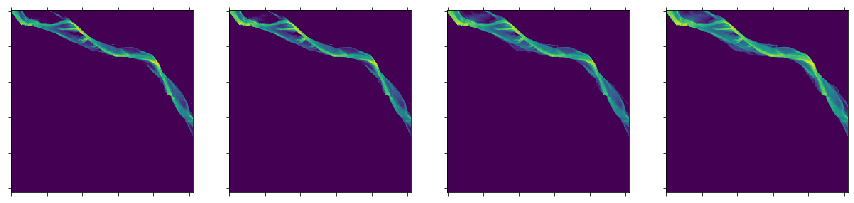

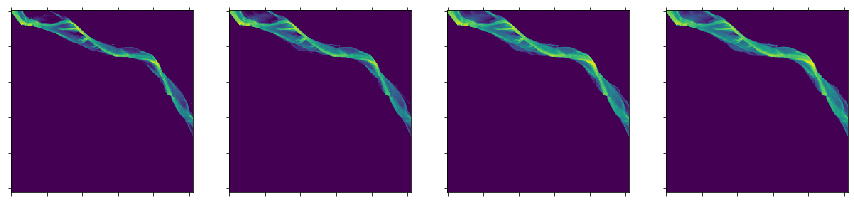

In [87]:
# Valid sequences
for i, batch in enumerate(X_train):
    for j, sequence in enumerate(batch):

        # first three channels (dep, vvx, vvy): x/y aligned
        #sequence = np.concatenate((sequence[:,:3,:,:], y_train[i,j,:,0,:,:].unsqueeze(0)), axis=0)

        fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for k,frame in enumerate(sequence):   # x frames
            axs[k].matshow(frame[0])

In [96]:
losses = []
errors = []
test_errors = []

batch 0 - loss 0.06943989545106888
batch 1 - loss 0.1654016524553299
batch 2 - loss 0.10411909967660904
batch 3 - loss 0.0593937449157238
batch 4 - loss 0.15158483386039734
batch 5 - loss 0.11793426424264908
batch 6 - loss 0.0500631146132946
batch 7 - loss 0.1860843449831009


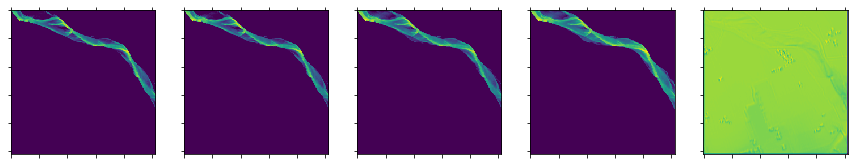

batch 0 - loss 0.06320779770612717
batch 1 - loss 0.15805940330028534
batch 2 - loss 0.09769392013549805
batch 3 - loss 0.053290802985429764
batch 4 - loss 0.14393456280231476
batch 5 - loss 0.1106366217136383
batch 6 - loss 0.04417942836880684
batch 7 - loss 0.17747078835964203
batch 0 - loss 0.057295266538858414
batch 1 - loss 0.1500009149312973
batch 2 - loss 0.09089557081460953
batch 3 - loss 0.04684271290898323
batch 4 - loss 0.13460636138916016
batch 5 - loss 0.10201235860586166
batch 6 - loss 0.03866094350814819
batch 7 - loss 0.1667879819869995
batch 0 - loss 0.05326676368713379
batch 1 - loss 0.1423446536064148
batch 2 - loss 0.08710654824972153
batch 3 - loss 0.04488983750343323
batch 4 - loss 0.12815521657466888
batch 5 - loss 0.09776046872138977
batch 6 - loss 0.039293788373470306
batch 7 - loss 0.1612803339958191


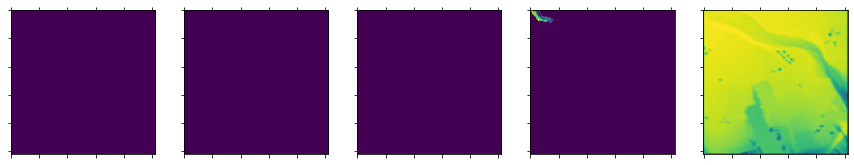

batch 0 - loss 0.05370461940765381
batch 1 - loss 0.13967742025852203
batch 2 - loss 0.08591246604919434
batch 3 - loss 0.043859824538230896
batch 4 - loss 0.1256956309080124
batch 5 - loss 0.095845527946949
batch 6 - loss 0.03799286484718323
batch 7 - loss 0.16003279387950897
batch 0 - loss 0.05246422812342644
batch 1 - loss 0.13906340301036835
batch 2 - loss 0.08532174676656723
batch 3 - loss 0.04354994371533394
batch 4 - loss 0.12565870583057404
batch 5 - loss 0.09583201259374619
batch 6 - loss 0.038073357194662094
batch 7 - loss 0.15997318923473358
batch 0 - loss 0.05247829481959343
batch 1 - loss 0.1390124261379242
batch 2 - loss 0.08535835891962051


KeyboardInterrupt: 

In [97]:
epochs = 200

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        # ---- Predicting
        _, last_states = net(X_train[0])
        outputs = last_states[0][-1]  # 0 for layer index, 0 for h index

        # ---- Loss and training
        loss = criterion(outputs,  y_train[i,:,:,0,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())

        print("batch {} - loss {}".format(i, loss.item()))

    if epoch % 3 == 0:

        k = np.random.randint(len(X_train))

        _, last_states = net(X_train[k])
        outputs = last_states[0][-1]  # 0 for layer index, 0 for h index

        test_loss = criterion(outputs[0],  y_train[k,:,:,0,:,:])
        #print("test loss: {}".format(test_loss.item()))

        #------------------------------
        fig, axs = plt.subplots(1, X_train.shape[2] + 1, figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        # pick random datapoint from batch
        x = np.random.randint(X_train[k].shape[0])

        for i,frame in enumerate(X_train[k,x]):
            axs[i].matshow(frame[0].cpu().detach().numpy())

        axs[i+1].matshow(outputs[x][0].cpu().detach().numpy())

        plt.show()
        #------------------------------

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

In [24]:
'''
num_run = len(os.listdir("runs/")) + 1
now = datetime.now()
foldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))
os.mkdir("runs/" + foldername)

weights_path = "runs/" + foldername + "/model.weights"
th.save(net.state_dict(), weights_path)
'''

'\nnum_run = len(os.listdir("runs/")) + 1\nnow = datetime.now()\nfoldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))\nos.mkdir("runs/" + foldername)\n\nweights_path = "runs/" + foldername + "/model.weights"\nth.save(net.state_dict(), weights_path)\n'

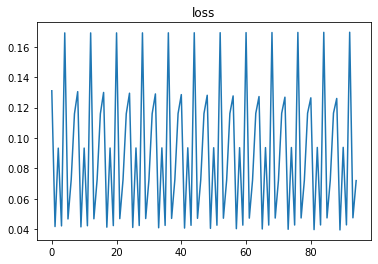

In [30]:
mpl.rcParams['text.color'] = 'k'

plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

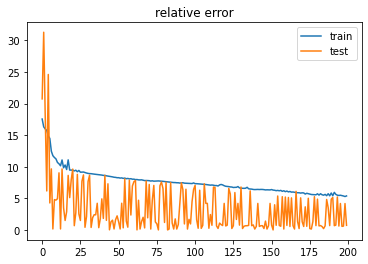

In [26]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


In [27]:
mpl.rcParams['text.color'] = 'w'
prep = Preprocessing()

k = 4
======== Past frames ========


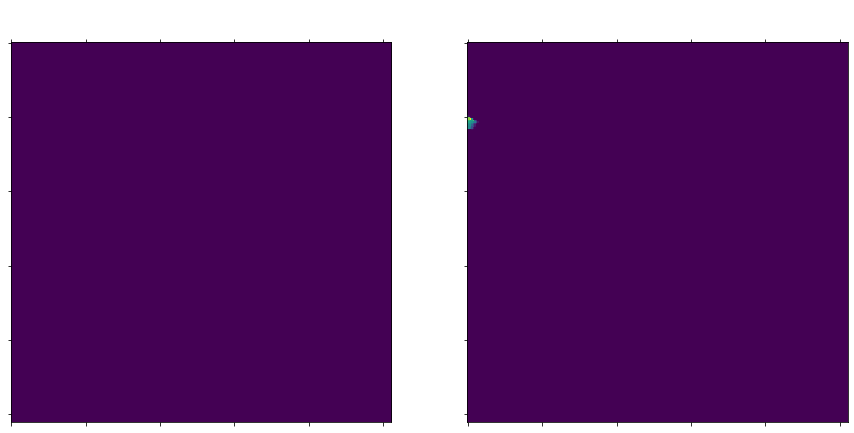

======== True Future vs Predicted frames ========


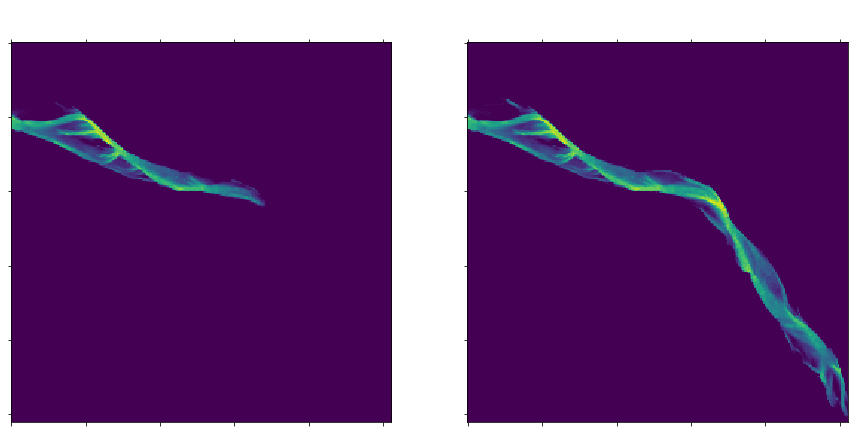

[[1.38497   1.4890387 1.6472039 1.681845  1.7259423]
 [1.4096096 1.5222852 1.6537913 1.689349  1.753241 ]
 [1.2188122 1.2962141 1.4281406 1.4494182 1.5186938]
 [1.134476  1.1967351 1.2965041 1.3054746 1.4190581]
 [1.3130611 1.3328977 1.4048684 1.3647956 1.6162078]]
#-------------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]



[[3.4392052 3.501412  3.6003442 3.6218252 4.1092973]
 [3.6598983 3.7052217 3.7982721 3.8278768 4.3921347]
 [3.5096087 3.519772  3.5940642 3.6025963 4.1965156]
 [4.0407133 4.0142846 4.0385365 4.0438952 4.795246 ]
 [3.8747966 3.800887  3.8086376 3.7790735 4.581322 ]]
#-------------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]





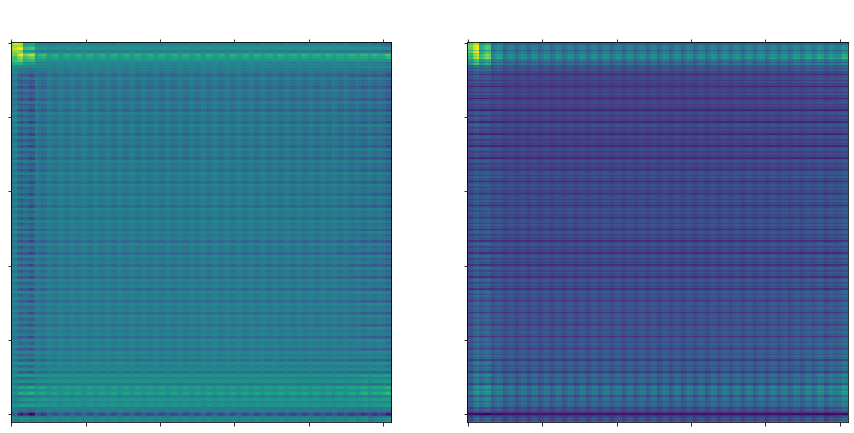

In [28]:
j = np.random.randint(len(y_test))
j = 3
m = 2
k = 4

print("k = {}".format(k))

#k = 5
input = th.unsqueeze(X_test[j, m], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0, 0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    frame = frame.cpu().detach().numpy()
    axs[i].matshow(frame)
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_test[j,m,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    attention_mask = outputs[0,1,i].cpu().detach().numpy()
    y_frame = frame.cpu().detach().numpy()
    y_true = y_test[j,m,0,i].cpu().detach().numpy()

    y_frame = np.dot(y_frame, attention_mask)
    y_true = np.dot(y_true, attention_mask)

    print(y_frame[:5,:5])
    print("#-------------")
    print(y_true[:5,:5])
    print("\n\n")

    ssim = prep.pytorch_ssim(y_true, y_frame).item()
    axs[i].matshow(y_frame)
    axs[i].set_title('ssim = {}'.format(ssim))

plt.show()
#------------------------------

k = 4
======== Past frames ========


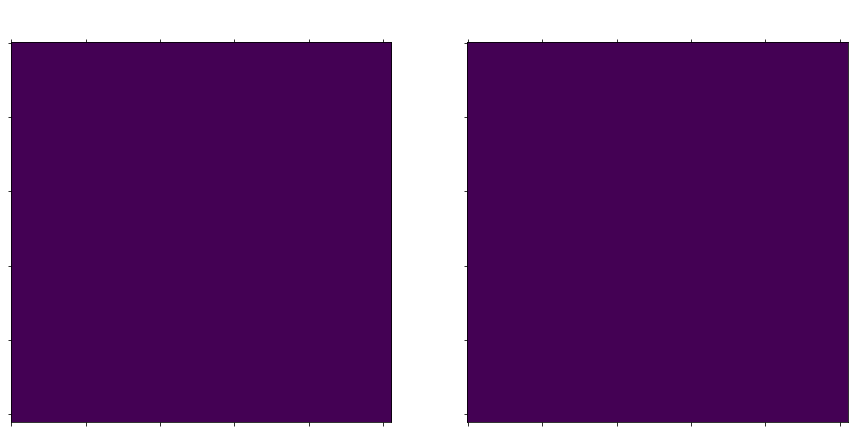

======== True vs Autoregressive Pred Frames  ========


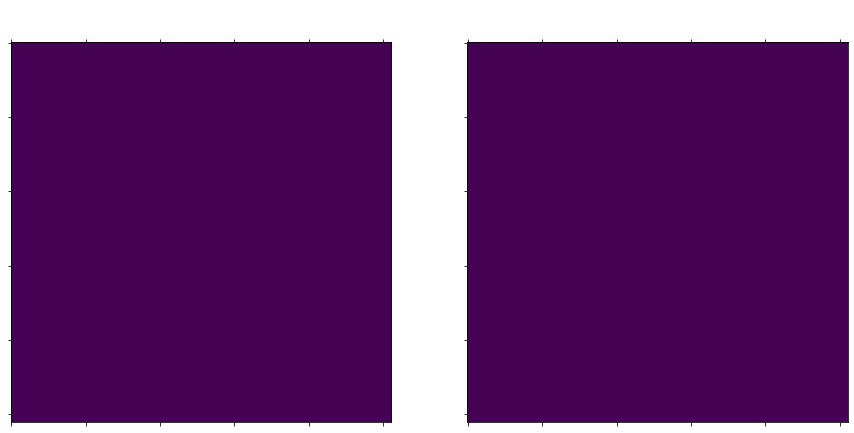

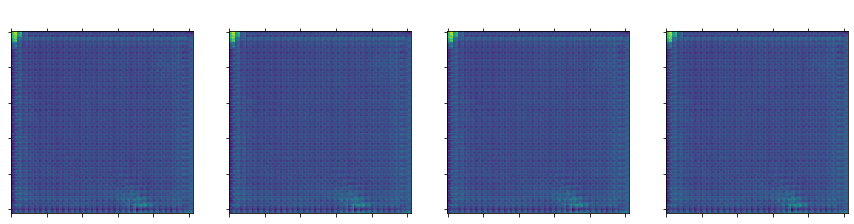

In [29]:
print("k = {}".format(k))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

true_means = []

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))
    true_means.append(frame.cpu().detach().numpy().mean())

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

predicted_means = []
for x in range(iterations):
    # first predicted frame only
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    # next frame = first predicted from output + btm map
    next_frame = output.detach()
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1)
    # added on top of (input sequence - first frame)
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    predicted_means.append(output[0,0,0].cpu().detach().numpy().mean())
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

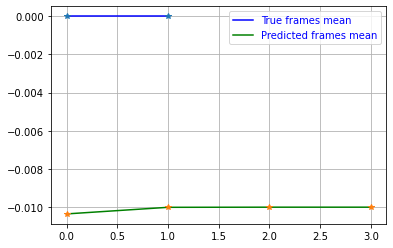

In [30]:
mpl.rcParams['text.color'] = 'b'

plt.clf()
plt.plot(range(len(true_means)), true_means,  "-b", label="True frames mean")
plt.plot(range(len(true_means)), true_means,  "*")

plt.plot(range(len(predicted_means)), predicted_means,  "-g", label="Predicted frames mean")
plt.plot(range(len(predicted_means)), predicted_means,  "*")
plt.grid()
plt.legend()
pass

In [31]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -0.124222           0.897250            0.051546            0.061615            
true                0.000000            2.182364            0.038984            0.203834            
